## Notebook to visualize a dataset


In [1]:
from notebook_imports import *

import torch
from torch.utils.data import DataLoader

from mattport.nerf.dataset.image_dataset import ImageDataset, collate_batch
from mattport.nerf.dataset.collate import CollateIterDataset, collate_batch_size_one
from mattport.nerf.dataset.utils import get_dataset_inputs_dict
from mattport.nerf.field_modules.ray_generator import RayGenerator
from mattport.structures.rays import RayBundle
from mattport.utils.io import get_absolute_path
from mattport.viewer.plotly import get_line_segments_from_lines
from mattport.structures.cameras import get_camera_model


from hydra import compose, initialize
from omegaconf import open_dict
import pprint
from tqdm import tqdm
import random

In [2]:
import goat
vis = goat.vis_utils.get_vis()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
goat.vis_utils.show_box_test(vis)

In [4]:
with initialize(config_path="../configs"):
    # cfg = compose(config_name="default.yaml")
    cfg = compose(config_name="default.yaml", overrides=["data/dataset=friends_TBBT-big_living_room"])

In [5]:
import os
from mattport.nerf.dataset.colmap_utils import read_cameras_binary, read_images_binary, read_pointsTD_binary

In [13]:
from mattport.nerf.dataset.friends import load_friends_data

In [40]:
dataset_inputs = load_friends_data("/shared/ethanweber/cartoons/data/colmap/smith_house_pair_manual_after", include_point_cloud=True)

[2930.31056439  960.          544.        ]
[4466.94830951 1024.          574.        ]


In [24]:
imdata = read_images_binary(os.path.join("/shared/ethanweber/mattport/data/friends/TBBT-big_living_room", "colmap", "images.bin"))

In [41]:
# cfg.data.dataset.data_directory = get_absolute_path(cfg.data.dataset.data_directory)
# dataset_inputs = get_dataset_inputs_dict(**cfg.data.dataset, splits=["train"])["train"]

In [46]:
import goat.threedvis.meshcat.geometry as g
import numpy as np
point_cloud = dataset_inputs.point_cloud
size = 0.1
vis["point_cloud"].set_object(
    g.PointCloud(position=np.transpose(np.array(point_cloud.xyz)),
                    color=np.transpose(np.array(point_cloud.rgb)) / 255.0, size=size)
)

In [47]:
# show dataset inputs with three.js
# goat.vis_utils.show_box_test(vis)
num_images_to_show = 200
for idx in tqdm(list(range(len(dataset_inputs.image_filenames)))[:num_images_to_show]):
    image = imageio.imread(dataset_inputs.image_filenames[idx])[:,:,:3]

    num_intrinsics_params = len(dataset_inputs.intrinsics[idx])
    camera_class = get_camera_model(num_intrinsics_params)
    camera_to_world = dataset_inputs.camera_to_world[idx]
    camera = camera_class(*dataset_inputs.intrinsics[idx].tolist(), camera_to_world=camera_to_world)
    K = camera.get_intrinsics_matrix()

    name = "train/{:06d}".format(idx)
    # height = 0.5
    displayed_focal_length = 0.5
    goat.vis_utils.draw_camera_frustum(vis, 
        name=name, 
        image=image, 
        K=K.numpy(), 
        pose=camera_to_world.double().numpy(),
        height=3.0,
        realistic=False,
        displayed_focal_length=0.0
        )



100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


In [8]:
image_dataset = ImageDataset(
            image_filenames=dataset_inputs.image_filenames, downscale_factor=dataset_inputs.downscale_factor
        )
iter_dataset = CollateIterDataset(
    image_dataset,
    collate_fn=lambda batch_list: collate_batch(
        batch_list, cfg.data.dataloader.num_rays_per_batch, keep_full_image=True
    ),
    num_samples_to_collate=cfg.data.dataloader.num_images_to_sample_from,
    num_times_to_repeat=cfg.data.dataloader.num_times_to_repeat_images,
)
dataloader = DataLoader(
    iter_dataset,
    batch_size=1,
    num_workers=cfg.data.dataloader.num_workers,
    collate_fn=collate_batch_size_one,
    pin_memory=True,
)
dataloader_iter = iter(dataloader)

ray_generator = RayGenerator(dataset_inputs.intrinsics, dataset_inputs.camera_to_world)

num_batches = 10
for _ in tqdm(range(num_batches)):
    batch = next(dataloader_iter)
    ray_bundle = ray_generator.forward(batch["indices"])
    break

  0%|          | 0/10 [00:03<?, ?it/s]


""

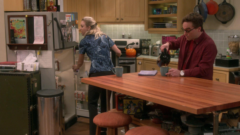

In [9]:
media.show_image(image_dataset.get_image(10))

In [10]:
def show_batch(batch):
    # set the color of the sampled rays
    c, y, x = [i.flatten() for i in torch.split(batch["local_indices"], 1, dim=-1)]
    batch["image"][c,y,x] = 1.0

    # batch["image"] is num_images, h, w, 3
    images = torch.split(batch["image"], 1, dim=0)
    image_list = [image[0] for image in images]
    image = torch.cat(image_list, dim=1) # cat along the width dimension

    # the white pixels are rays
    media.show_image((image*255).to(torch.uint8))

def sample_and_show_batch():
    batch = next(iter(dataloader))
    show_batch(batch)
    return batch

""

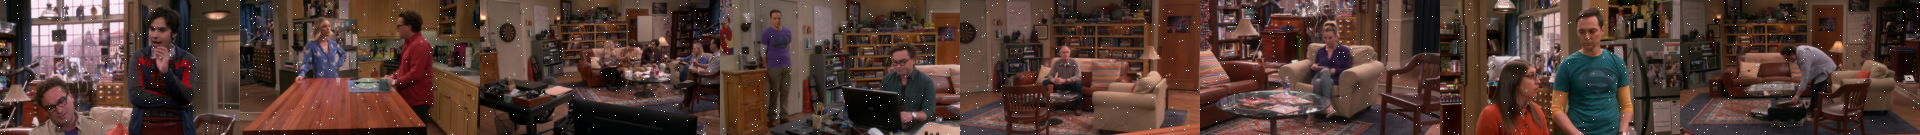

In [11]:
batch = sample_and_show_batch()

In [12]:
ray_indices = batch["indices"]
ray_bundle = ray_generator(ray_indices)

In [23]:
skip = 1
size = 8
data = []
data += [go.Scatter3d(
    x=ray_generator.camera_to_world[::skip,0,3],
    y=ray_generator.camera_to_world[::skip,1,3],
    z=ray_generator.camera_to_world[::skip,2,3],
    mode='markers',
    name="origins",
    marker=dict(color='rgba(0, 0, 0, 1)', size=size)
)]

In [24]:
near_plane = cfg.graph.network.near_plane
far_plane = cfg.graph.network.far_plane
lines = torch.stack([ray_bundle.origins + ray_bundle.directions * near_plane,
                     ray_bundle.origins + ray_bundle.directions * far_plane
                    ], dim=1).tolist() # (num_rays, 2, 3)
lines = torch.tensor(random.sample(lines, k=100))

In [25]:
data += get_line_segments_from_lines(lines)

In [26]:
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    scene=go.layout.Scene(
        aspectmode="data",
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.25, y=1.25, z=1.25)
        )
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
fig.write_image("temp.png")
plotly_image = imageio.imread("temp.png")
